In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Augmentation

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cpu
Torchvision Version:  0.12.0+cpu


In [4]:
from pathlib import Path

import cv2
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import numpy as np
# import torchvision.transforms as T
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset,RandomSampler,SequentialSampler
from torchvision import models
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import random
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm
import torch.nn.functional  as F



In [5]:
data_dir = "../input/the-oxfordiiit-pet-dataset/images/images/"

model_name = "resnet50"

num_classes = 37

# Batch size for training (change depending on how much memory you have)
batch_size =  32

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Helper functions

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Set parameters - required gradients

In [7]:
df = pd.read_csv(
    "../input/the-oxfordiiit-pet-dataset/annotations/annotations/list.txt",
    delimiter=" ",
    skiprows=6,
    header=None,
    names=["stem", "class_id", "species", "breed"]
)
df["class_name"] = df.stem.map(lambda x: x.split("_")[0])
df["image"] = df.stem.map(lambda x: f"../input/the-oxfordiiit-pet-dataset/images/images/{x}.jpg")
df["trimap"] = df.stem.map(lambda x: f"../input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/{x}.png")
df



,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
1,Abyssinian_101,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
2,Abyssinian_102,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
3,Abyssinian_103,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
4,Abyssinian_104,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
...,...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7345,yorkshire_terrier_97,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7346,yorkshire_terrier_98,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7347,yorkshire_terrier_99,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...


In [8]:
df[["class_id", "class_name"]].drop_duplicates().reset_index(drop=True).to_csv("breed_id.csv", index=False)

In [9]:
df_2 = pd.read_csv("./breed_id.csv")
df_2

,class_id,class_name
0,1,Abyssinian
1,2,american
2,3,american
3,4,basset
4,5,beagle
5,6,Bengal
6,7,Birman
7,8,Bombay
8,9,boxer
9,10,British


stem                                             Abyssinian_100
class_id                                                      1
species                                                       1
breed                                                         1
class_name                                           Abyssinian
image         ../input/the-oxfordiiit-pet-dataset/images/ima...
trimap        ../input/the-oxfordiiit-pet-dataset/annotation...
Name: 0, dtype: object


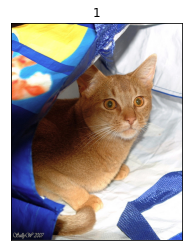

In [10]:
print(df.iloc[0])
img = Image.open(df.image[0])
annot = df.class_id[0]

plt.imshow(img)
plt.title(annot)
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
# sanity check
if False:
    for img, annot in tqdm(zip(df.image, df.trimap), total=len(df)):
        Image.open(img).verify()
        Image.open(annot).verify()

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Load the models

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "densenet201":
        """ Densenet 201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Loading Data

## RandAugment - for strong augmentation

In [14]:
def AutoContrast(image,**kwarg):
    return PIL.ImageOps.autocontrast(image)
def Brightness(image,vec,bias=0):
    assert 0.1<= vec<= 1.9
    return PIL.ImageEnhance.Brightness(image).enhance(vec)
def Color(image,vec):
    assert 0.1<=vec<=1.9
    return PIL.ImageEnhance.Color(image).enhance(vec)

def Contrast(image,vec):
    assert 0.1<=v<=1.9
    return PIL.ImageEnhance.Contrast(image).enhance(vec)
def CutoutAbs(image,vec):
    if v<0:
        return image
    
    w,h = image.size
    x_0 = np.random.uniform(w)
    y_0 = np.random.uniform(h)
    
    x_0 = int(max(0,x_0-vec/2.))
    y_0 = int(max(o,y_0-vec/2.))
    
    x_1 = min(w,x_0+vec)
    y_1 = min(h,y_0+vec)
    xy = (x_0,y_0,x_1,y_1)
    
    #making  grey rectangle
    grey = (125,123,114)
    image = image.copy()
    PIL.ImageDraw.Draw(Image).rectangle(xy,grey)
    return image

def Cutout(image,vec):
    assert 0.0<= vec<= 0.2
    if vec<=0.:
        return image
    vec = vec*image.size[0]
    return CutoutAbs(image,vec)

def Equalize(image,**kwarg):
    return PIL.ImageOps.equalize(image)

def Identity(image,**kwarg):
    return image

def Invert(image,**kwarg):
    return PIL.ImageOps.invert(image)

def Posterize(image,**kwarg):
    vec = int(vec)
    max_vec = max(1,vec)
    return PIL.ImageOps.posterize(image,max_vec)
def Rotate(image,vec):
    assert -30<=v<30
    if random.random()<0.5:
        vec = -vec
    return image.rotate(vec)
def Sharpness(image, vec): 
    assert 0.1 <= vec <= 1.9
    return PIL.ImageEnhance.Sharpness(image).enhance(vec)

    
def ShearX(image, vec): 
    assert -0.3 <= vec <= 0.3
    if random.random() > 0.5:
        vec = -vec
    return image.transform(image.size, PIL.Image.AFFINE, (1, vec, 0, 0, 1, 0))
def ShearY(image, vec): 
    assert -0.3 <= vec <= 0.3
    if random.random() > 0.5:
        vec = -vec
    return image.transform(image.size, PIL.Image.AFFINE, (1, 0, 0, vec, 1, 0))

def Solarize(image, vec): 
    assert 0 <= vec <= 256
    return PIL.ImageOps.solarize(image, vec)

def SolarizeAdd(image, sol_addition=0, sol_threshold=128):
    image_array = np.array(img).astype(np.int)
    image_array = image_array + sol_addition
    image_array = np.clip(image_array, 0, 255)
    image_array = image_array.astype(np.uint8)
    image = Image.fromarray(image_array)
    return PIL.ImageOps.solarize(image, sol_threshold)

def TranslateX(image, vec): 
    assert -0.45 <= vec <= 0.45
    
    if random.random() > 0.5:
        vec = -vec
    vec = vec * image.size[0]
    return image.transform(image.size, PIL.Image.AFFINE, (1, 0, vec, 0, 1, 0))

def TranslateY(image, vec): 
    assert -0.45 <= vec <= 0.45
    
    if random.random() > 0.5:
        vec = -vec
    vec = vec * image.size[1]
    return image.transform(image.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, vec))

def Abs_TranslateX(image,vec):
    assert 0<=vec
    if random.random()>0.5:
        vec =-vec
        return image.transform(image.size, PIL.Image.AFFINE, (1, 0, vec, 0, 1, 0))
def Abs_TranslateY(image, vec): 
    assert 0 <= vec
    if random.random() > 0.5:
        vec = -vec
    return image.transform(image.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, vec))

    

def ran_augment():
    rand_aug = [(AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (Abs_TranslateX, 0., 100),
        (Abs_TranslateY, 0., 100),]
    return rand_aug

class RandAugmentation(object):
    def __init__(self,n,m):
        assert n>=1
        assert 1<=m<=10
        self.n = n
        self.m = m
        self.augmentations = ran_augment()
    def __call__(self,image):
        op_trans = random.choices(self.augmentations,k=self.n)
        for ops,min_value,max_value in op_trans:
            norm = (float(self.m)/30)
            diff = float(max_val-min_val) + min_val
            val = norm*diff
            image = op_trans(image,value)
        return image
class FixMatchTransform(object):
    def __init__(self):
        self.weakaug = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(size = 32,padding=int(32*0.125),padding_mode='reflect')])
        self.strongaug = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(size = 32,padding=int(32*0.125),padding_mode='reflect'),
                                            RandAugmentation(n=2,m=10)])
        self.normaug = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))])
    def __call__(self,image):
        
        weak_aug = self.weakaug(image)
        weak_aug_norm = self.normaug(weak_aug)
        
        strong_aug = self.strongaug(image)
        strong_aug_norm = self.normaug(strong_aug)
        
        
        return weak_aug_norm , strong_aug_norm
        
    
      
        
    
        
    


    
    
    
    
        
    
    
    
    
    
     

In [15]:
df

,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
1,Abyssinian_101,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
2,Abyssinian_102,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
3,Abyssinian_103,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
4,Abyssinian_104,1,1,1,Abyssinian,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
...,...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7345,yorkshire_terrier_97,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7346,yorkshire_terrier_98,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...
7347,yorkshire_terrier_99,37,2,25,yorkshire,../input/the-oxfordiiit-pet-dataset/images/ima...,../input/the-oxfordiiit-pet-dataset/annotation...


In [16]:
def  ssl_split(dataframe,labels,num_labeled=5000):
    global batch_size
    label_per_class = num_labeled//37 #number of classes
    labels = dataframe.class_id
    labeled_idx = []
    unlabelled_idx = np.array(range(len(list(labels)))) # TAKING  all data 0
    for num in range(1,38):
        idx = np.where(labels==i)[0]
        idx = np.random.choice(idx,label_per_class,False)
        labelled_idx.extend(idx)
    labelled_idx = np.array(labelled_idx)
    assert len(labelled_idx) == num_labeled #sanity check
    
    return labelled_idx, unlabelled_idx
#     if num_labeled < batch_size:
#         expanded_num_img = math.ceil(batch_size*)
        


    

In [ ]:
# data_transforms = {
#     'Strong_aug': alb.Compose([
#         alb.equalize(),
#         alb.Rotate(),
#         alb.solarize(),
#         alb.posterize()
#         alb.brightness_contrast_adjust
#         alb.VerticalFlip(p=0.5),alb.HorizontalFlip(p=0.5),
#         alb.RandomScale(),
#         alb.Rotate(),
#         alb.RandomBrightnessContrast(p=0.2),
#         alb.SmallestMaxSize(input_size),alb.RandomCrop(input_size,input_size),
#         alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),

In [ ]:
# class  ssl_Dataset:
#     def __init__(self,df,tfm):
#         self.df = df
#         self.tfm = tfm
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, i):
#         img = Image.open(self.df.image.iloc[i]).convert('RGB')
#         img = np.asarray(img)
#         label = int(self.df.class_id.iloc[i])-1
#         if self.tfm:
#             augmented = self.tfm(image=img)
#             img = augmented["image"]
#         return img, label
#     def get_aug_dataset(self,use_strong_aug = False, strong_aug_transform =False,one_hot_enc = False):
#         data_img = Image.open(self.df.image.iloc[i]).convert('RGB')
#         data_img = np.asarray(data_img)
        
        
        
        
        
        
        
        
        
        
        
        
    

In [17]:
class Dataset(Dataset):
    def __init__(self, df, tfm=False):
        self.df = df
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        img = Image.open(self.df.image.iloc[i]).convert('RGB')
        img = np.asarray(img)
        label = int(self.df.class_id.iloc[i])-1
        if self.tfm:
            augmented = self.tfm(image=img)
            img = augmented["image"]
        return img, label # class id is 1-indexed

In [ ]:
sk_fold = StratifiedKFold(5)
train_id , val_id = next(iter(sk_fold.split(df,df.class_id)))
print(len(train_id))
print(len(val_id))
train_df = df.iloc[train_id]
val_df = df.iloc[val_id]
train_labelled , train_unlabelled


In [ ]:
def get_data()

In [31]:
seed_everything(42)
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': alb.Compose([
        alb.VerticalFlip(p=0.5),alb.HorizontalFlip(p=0.5),
        alb.RandomScale(),
        alb.Rotate(),
        alb.RandomBrightnessContrast(p=0.2),
        alb.SmallestMaxSize(input_size),alb.RandomCrop(input_size,input_size),
        alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': alb.Compose([
        alb.SmallestMaxSize(input_size),alb.CenterCrop(input_size,input_size),
        alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
}
 
img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)
print("Initializing Datasets and Dataloaders...")

def denorm(x):
    img_x = x*img_std + img_mean
    return img_x
# Create training and validation datasets
sk_fold = StratifiedKFold(5)
train_id , val_id = next(iter(sk_fold.split(df,df.class_id)))
print(len(train_id))
print(len(val_id))
train_df = df.iloc[train_id]
val_df = df.iloc[val_id]
f

train_dataset = Dataset(train_df,tfm= data_transforms['train'])
val_dataset = Dataset(val_df,tfm=data_transforms['val'])
image_datasets = {'train':train_dataset,'val':val_dataset}
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Datasets loaded and ready")

Initializing Datasets and Dataloaders...
5879
1470
Datasets loaded and ready


In [ ]:
for _ in range(3):
    img, label = train_dataset[3]
    plt.imshow(denorm(img.numpy().transpose(1,2,0)))
    plt.title("%d" % label)
    plt.xticks([]); plt.yticks([])
    plt.show()

In [37]:
# for i in range(0,30):
#     _ , label = train_dataset[i]
#     print(label)

## Optimizer 

In [ ]:
# # Setup the loss fxn
# criterion = nn.CrossEntropyLoss()


In [ ]:
# class LitModelTasks(pl.LightningModule):
#     def __init__(self,train_df,val_df):
#         super().__init__()
#         self.train_df = train_df
#         self.val_df = val_df
#     def setup(self,stage=None):
#         global data_transforms
#         global model_ft
#         global criterion
#         self.model = model_ft
#         self.train_dataset = Dataset(self.train_df,tfm=data_transforms['train'])
#         self.val_dataset = Dataset(self.val_df,tfm=data_transforms['val'])
#         self.loss_function = criterion
#     def forward_fn(self,x):
#         return self.model(x)
#     def train_dataset_loader(self):
#         global batch_size
#         dl_train = Dataloader(self.train_dataset,batch_size= batch_size,pin_memory=True)
#         return dl_train
#     def val_dataset_loader(self):
#         global batch_size
#         dl_val =Dataloader(self.val_dataset,batch_size=batch_size,pin_memory =True)
#         return dl_val
#     def training_cycle(self,batch,b_id):
#         x,t_s = batch
#         y = self.model(x)
#         loss = self.loss_function(y,t_s)
#         return loss
#     def validation_cycle(self,batch,b_id):
#         x,t_s = batch
#         y = self.model(x)
#         loss = self.loss_function(y,t_s)
    
        

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(params_to_update,lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
optimizer_ft = optim.Adam(params_to_update,lr=3e-4,weight_decay=0.001,amsgrad=False)

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
# plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()